In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion() 

### Data

In [2]:
from six.moves import urllib

opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)

# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Data 확인

In [3]:
images, labels = next(iter(train_loader))  # 첫 번째 batch
print('Images :', images.shape)
print('Labels :',  labels.shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Images : torch.Size([64, 1, 28, 28])
Labels : torch.Size([64])


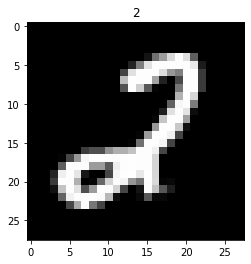

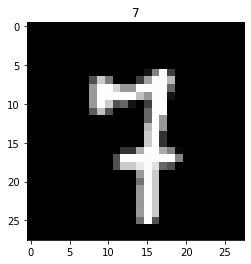

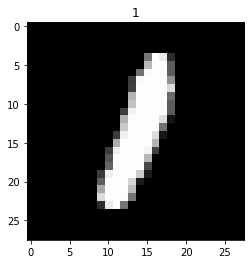

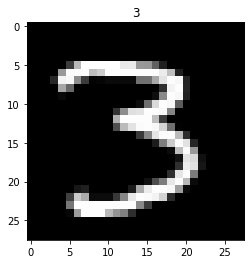

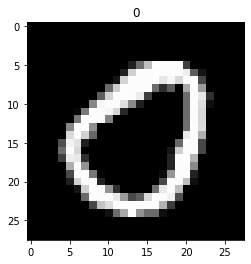

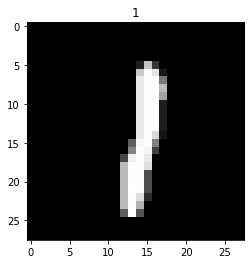

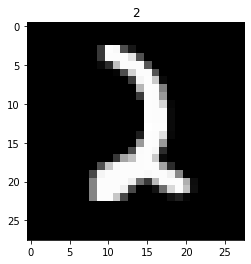

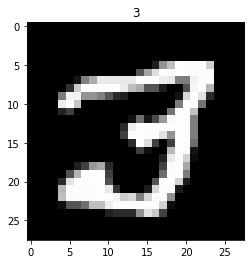

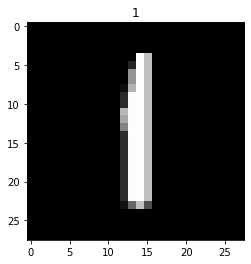

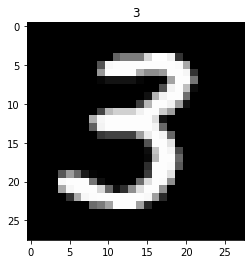

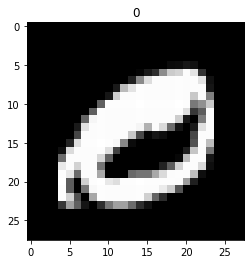

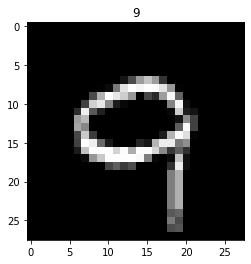

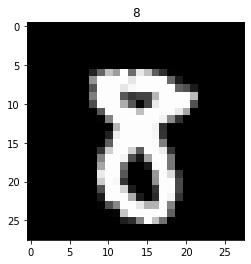

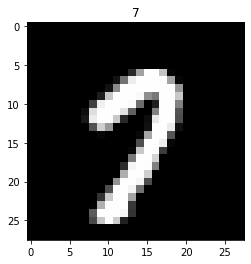

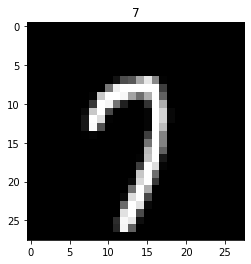

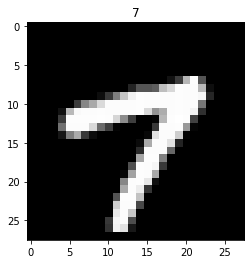

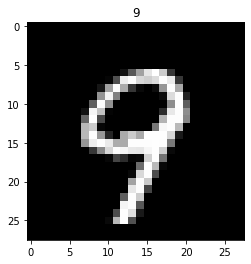

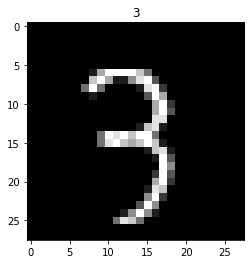

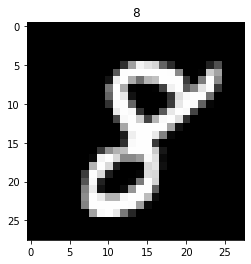

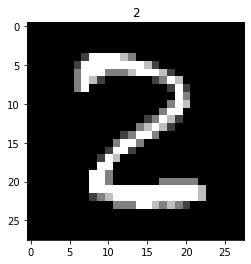

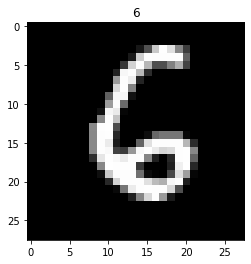

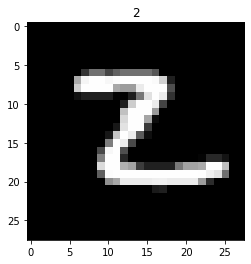

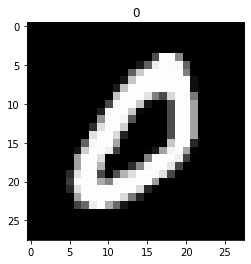

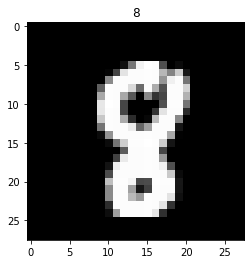

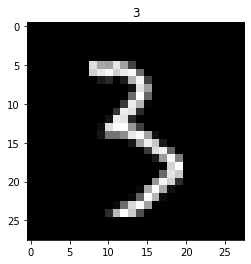

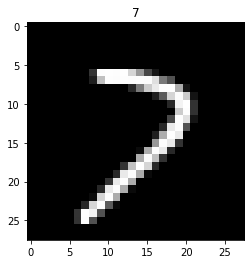

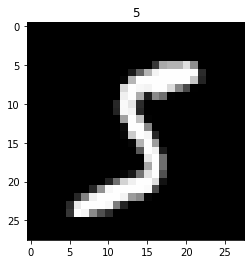

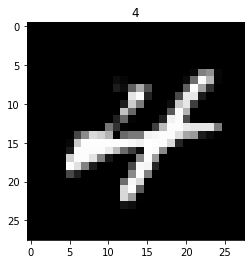

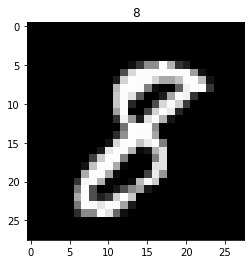

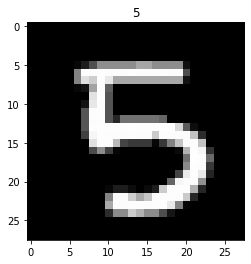

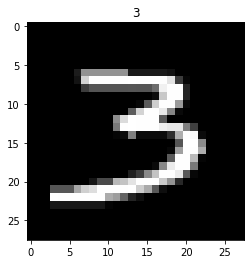

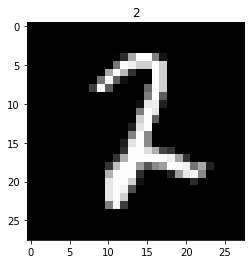

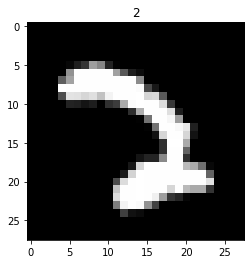

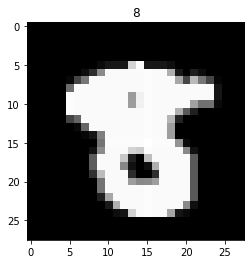

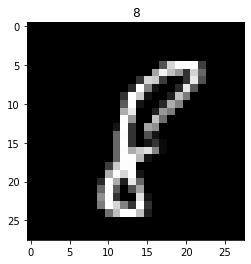

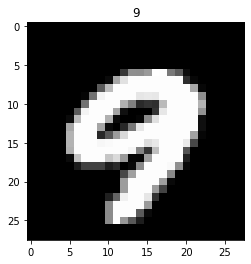

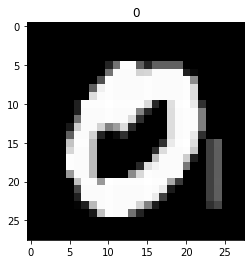

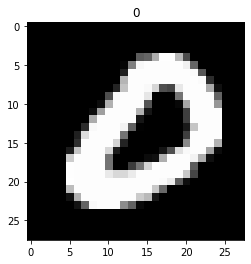

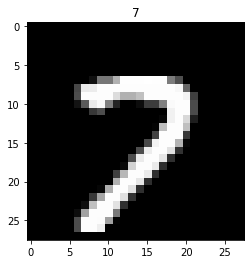

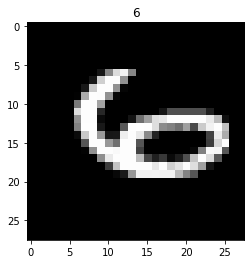

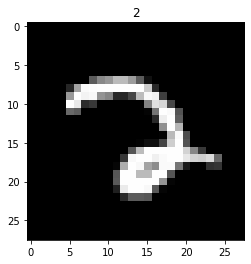

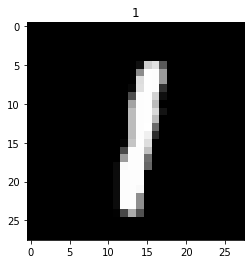

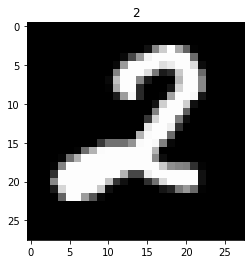

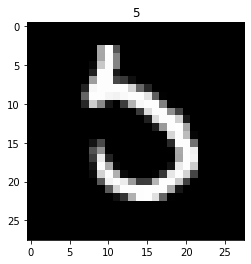

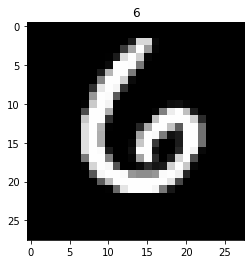

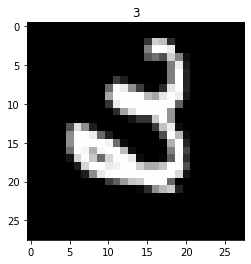

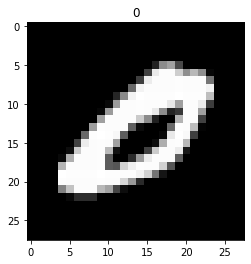

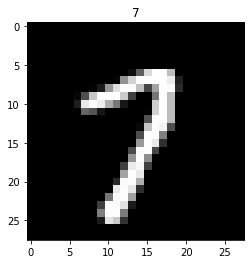

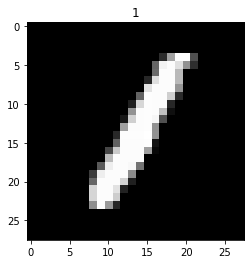

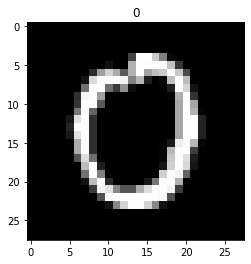

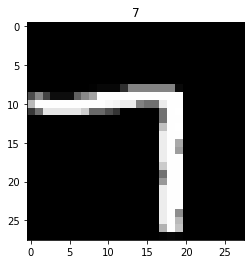

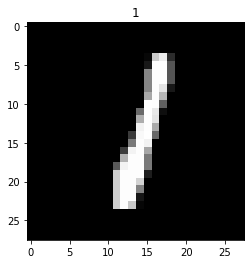

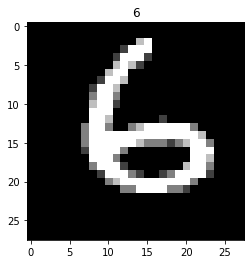

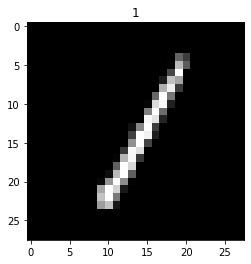

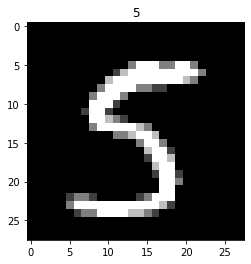

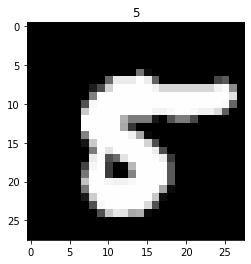

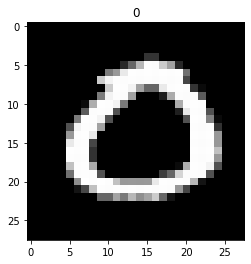

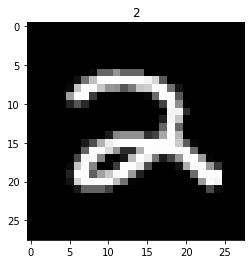

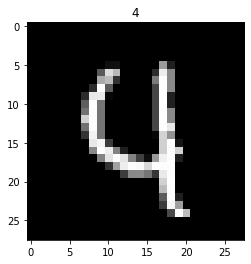

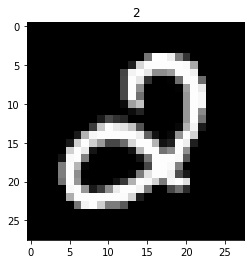

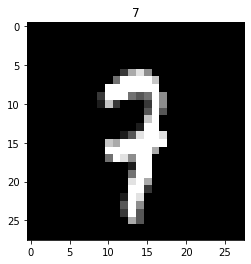

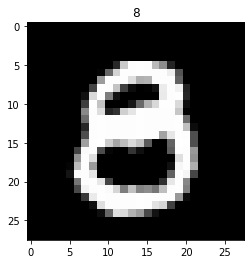

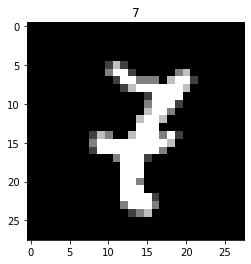

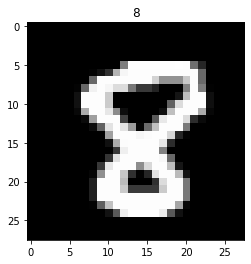

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


for i in range(images.shape[0]):
    torch_image = torch.squeeze(images[i])
    image = torch_image.numpy()
    # print('image :', image.shape) - 28x28

    label = labels[i].numpy()

    plt.title(label)
    plt.imshow(image,'gray')
    plt.show()

### Network

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)  # linear 연산이 가능하도록 1D로 변환
        
        theta = self.fc_loc(xs)  # affine 변환을 위한 파라미터 획득
        theta = theta.view(-1, 2, 3)
       
        grid = F.affine_grid(theta, x.size())  # https://pytorch.org/docs/1.9.0/generated/torch.nn.functional.affine_grid.html
        x = F.grid_sample(x, grid)  # https://pytorch.org/docs/stable/generated/torch.nn.functional.grid_sample.html

        return x, theta, grid

    def forward(self, x):
        # transform the input
        x, _, _ = self.stn(x)  # 정규화된 이미지 (input과 동일한 크기)

        # Perform the usual forward pass (일반적인 classification 용)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

### Process of STN

In [14]:
# Input
x = torch.randn([64, 1, 28, 28])

localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

![image](https://user-images.githubusercontent.com/44194558/151283776-30ba0a4e-f372-4f75-bc91-af51af65668e.png)

In [15]:
print('Input of STN :', x.shape)  # distorted image
print()
xs = localization(x)
print('xs :', xs.shape)

xs = xs.view(-1, 10 * 3 * 3)  # reshape for F.C layer
print('xs :', xs.shape)

theta = fc_loc(xs)
print()
print('theta :', theta.shape)

theta = theta.view(-1, 2, 3)  # reshape for define 2x3 affine matrix
print('theta :', theta.shape)  
print()

grid = F.affine_grid(theta, x.size())  
print('grid :', grid.shape)  # (N, H_out, W_out, 2)
print()

x = F.grid_sample(x, grid)
print('Output of STN :', x.shape)  # reconstructed image(정규화) - (N, C, H_out, W_out)

Input of STN : torch.Size([64, 1, 28, 28])

xs : torch.Size([64, 10, 3, 3])
xs : torch.Size([64, 90])

theta : torch.Size([64, 6])
theta : torch.Size([64, 2, 3])

grid : torch.Size([64, 28, 28, 2])

Output of STN : torch.Size([64, 1, 28, 28])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [16]:
localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

def stn(x):
    xs = localization(x)
    xs = xs.view(-1, 10 * 3 * 3)
    theta = fc_loc(xs)
    theta = theta.view(-1, 2, 3)

    grid = F.affine_grid(theta, x.size())
    output = F.grid_sample(x, grid)

    return output

In [17]:
stn_images = stn(images)
print('STN images :', stn_images.shape)

STN images : torch.Size([64, 1, 28, 28])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [18]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

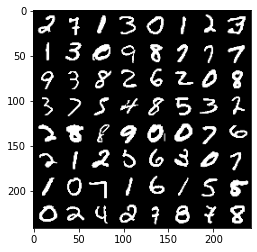

In [19]:
out = torchvision.utils.make_grid(images)  # distorted images
imshow(out)

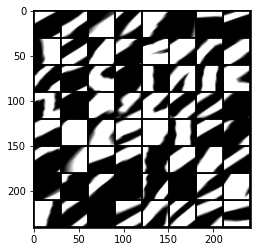

In [20]:
out = torchvision.utils.make_grid(stn_images)  # STN output (미학습 상태)
imshow(out)

### Train

In [21]:
# 네트워크
model = Net().to(device)

In [22]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure the STN performances on MNIST.
#

def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

In [23]:
for epoch in range(1, 20 + 1):
    train(epoch)
    test()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify ali

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.293217
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.870394


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.3275, Accuracy: 8988/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.393095
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.402997

Test set: Average loss: 0.1396, Accuracy: 9560/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.407955
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.131095

Test set: Average loss: 0.0929, Accuracy: 9698/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.239052
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.149490

Test set: Average loss: 0.0732, Accuracy: 9771/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.320100
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.349216

Test set: Average loss: 0.1748, Accuracy: 9462/10000 (95%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.256801
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.485857

Test set: Average loss: 0.0651, Accuracy: 9798/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.252531
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.188646

Test set: Average loss: 0.0586, Accuracy: 9814/10000 (98%)

Tra

In [30]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)
        print('data :', data.shape, type(data))

        input_tensor = data
        print('Input tensor:', input_tensor.shape, type(input_tensor))
        transformed_input_tensor, theta, grid = model.stn(data)

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


data : torch.Size([64, 1, 28, 28]) <class 'torch.Tensor'>
Input tensor: torch.Size([64, 1, 28, 28]) <class 'torch.Tensor'>


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


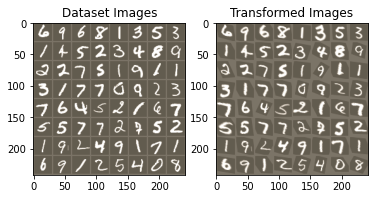

In [31]:
visualize_stn()

plt.ioff()
plt.show()

In [37]:
print(theta.shape)
print(grid.shape)

torch.Size([64, 2, 3])
torch.Size([64, 28, 28, 2])


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

### 학습된 STN 확인

In [32]:
model.stn

<bound method Net.stn of Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
  )
  (fc_loc): Sequential(
    (0): Linear(in_features=90, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=6, bias=True)
  )
)>

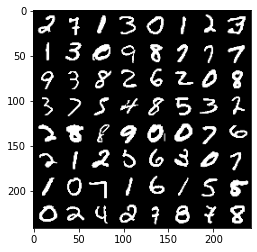

In [44]:
out = torchvision.utils.make_grid(images)  # distorted images
imshow(out)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


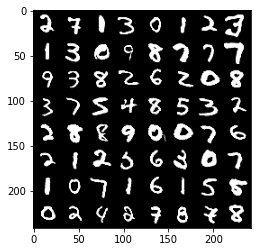

In [45]:
input_images = images.to(device)
output_images, theta, grid = model.stn(input_images)

out = torchvision.utils.make_grid(output_images)  # STN output images
imshow(out.cpu())

### 단일 이미지 test

In [90]:
single_image = images[0]
single_image = torch.unsqueeze(single_image, 0)  # input 크기를 맞추기 위해 batch 차원 추가
single_image = single_image.to(device)

with torch.no_grad():
    output_image, theta, grid = model.stn(single_image)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


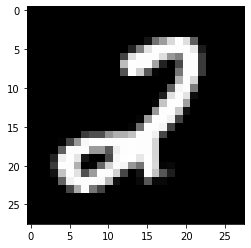

In [91]:
torch_single_image = torch.squeeze(single_image)
torch_single_image = torch_single_image.cpu()
image = torch_single_image.numpy()

plt.imshow(image, 'gray')
plt.show()

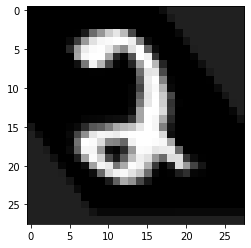

In [92]:
torch_output_image = torch.squeeze(output_image)
torch_output_image = torch_output_image.cpu()
image = torch_output_image.detach().numpy()

plt.imshow(image, 'gray')
plt.show()

In [93]:
theta

tensor([[[ 1.0178e+00, -7.1878e-01,  4.6405e-02],
         [ 6.6209e-04,  1.0150e+00,  7.6979e-02]]], device='cuda:0')

In [65]:
grid.shape

torch.Size([1, 28, 28, 2])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


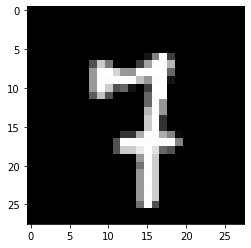

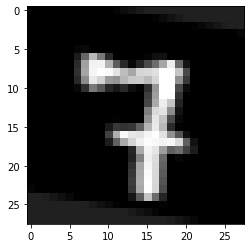

In [52]:
single_image = images[1]
single_image = torch.unsqueeze(single_image, 0)  # input 크기를 맞추기 위해 batch 차원 추가
single_image = single_image.to(device)

output_image, theta, grid = model.stn(single_image)

torch_single_image = torch.squeeze(single_image)
torch_single_image = torch_single_image.cpu()
image = torch_single_image.numpy()

plt.imshow(image, 'gray')
plt.show()

torch_output_image = torch.squeeze(output_image)
torch_output_image = torch_output_image.cpu()
image = torch_output_image.detach().numpy()

plt.imshow(image, 'gray')
plt.show()

In [59]:
theta = theta.cpu()
theta.detach

<function Tensor.detach>

In [60]:
theta

tensor([[[ 7.9866e-01,  3.4841e-02, -2.7106e-04],
         [-2.0683e-01,  1.0914e+00,  3.8764e-02]]], grad_fn=<ToCopyBackward0>)

### New image

In [121]:
import cv2
from torchvision.transforms import ToTensor

img1 = cv2.imread('/content/211203_3_rgb.bmp')
img2 = cv2.imread('/content/211204_3_rgb.bmp')

img1 = cv2.resize(img1, (64, 64))
img2 = cv2.resize(img2, (64, 64))

# Numpy to Tensor
tf_toTensor = ToTensor() 

img1_torch = tf_toTensor(img1)
img1_torch = torch.unsqueeze(img1_torch, 0)

img2_torch = tf_toTensor(img2)
img2_torch = torch.unsqueeze(img2_torch, 0)

print('img1 Tensor :', img1_torch.shape)
print('img2 Tensor :', img2_torch.shape)

img1 Tensor : torch.Size([1, 3, 64, 64])
img2 Tensor : torch.Size([1, 3, 64, 64])
